# Uebung 4 Mehrklassenklassifikation mit Neuronalen Netzen


## Imports

In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Globale Variablen
Definiere an dieser Stelle alle Variablen, die global verwendet werden, z.B.: Pfadnamen

In [2]:
# Define path to data
# DATA_PATH = "../data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images"
DATA_PATH = r"C:\Users\hqpet\Desktop\BildAuto_Hausaufgabe\BGA2_SoSe22-master2\BGA2_SoSe22-master\Ub4\data\GTSRB_Final_Training_Images\GTSRB\Final_Training\Images"

CLASS_ID_SIGN_MAP = "../data/GTSRB_Final_Training_Images/GTSRB/Final_Training/tf_signs_mapping.csv"

## Datenaufbereitung
Hinweise findest du hier: https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing

In [3]:
def readTrafficSigns(rootpath):
    """
    Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels
    
    """
    
    images = []
    labels = []
    
    # loop over all 42 classes
    for c in range(0,43):
        # subdirectory for class
        prefix = rootpath + '/' + format(c, '05d') + '/'
        
        # annotations file
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv')
        
        # csv parser for annotations file
        gtReader = csv.reader(gtFile, delimiter=';')
        
        # Skip header
        next(gtReader)
        
        # loop over all images in current annotations file
        for row in gtReader:
            # the 1th column is the filename
            images.append(plt.imread(prefix + row[0]))
            
            # the 8th column is the label
            labels.append(row[7])
            
        gtFile.close()
    
    return images, labels

def resizeImages(images, width=32, height=32):
    """
    Resize image to unify dimensions of the images
    
    """
    # Initialization
    unified_img = []
    normalized_img = []
    
    # Resize images
    for img in images:
        img = img.copy()
        unified_img.append(cv2.resize(img, (width, height)))
        
    # Normalize 
    for img in unified_img:
        R, G, B = cv2.split(img)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        normalized_img.append(cv2.merge((img_r, img_g, img_b)))
        
    print("Image Size: {} x {}".format(width, height))
        
    return normalized_img, width, height

def plotImages(X, labels, title, width=32, height=32):
    
    fig, axes = plt.subplots(
        3,15,
        figsize=(15,3),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i], cmap="gray")
        ax.text(2, 30, str(labels[i]), fontsize=15, c="white")
        
    fig.suptitle(title, fontsize=10)
    
def one_hot_encode(y):
    """
    Converts featuers from List of strings to one hot encoded labels
    """
    
    class_ids = y.astype(np.int)
    encoded = pd.get_dummies(class_ids).to_numpy()
    
    return encoded

def one_hot_decode(y, y_encoded):
    """
    Decodes one hot encoded data
    """
    
    class_ids = y.astype(np.int)
    decoded = pd.DataFrame(y_encoded).idxmax(1).astype(str).to_numpy()
    
    return decoded
        
def preprocessData(rootpath):
    """
    Loads the data and performs necessary preprocessing steps
    
    Parameters
    ----------
    path to the traffic sign data, for example './GTSRB/Training'
    
    Returns
    -------
    X_train : numpy.Array
    X_test  : numpy.Array
    y_tain  : numpy.Array
    y_test  : numpy.Array
    
    """
    
    # Load Data
    images, labels = readTrafficSigns(rootpath)
    
    # Unify image dimensions
    unified_img, max_width, max_height = resizeImages(images, width=32, height=32)
    
    # Convert list of labels to array of labels
    unified_img = np.array(unified_img)
    labels = np.array(labels)
    
    # 
    shuffle_indexes = np.arange(unified_img.shape[0])
    np.random.shuffle(shuffle_indexes)
    images_shuffled = unified_img[shuffle_indexes]
    labels_shuffled = labels[shuffle_indexes]
    
    # Perform train test split
    X_train, X_rest, y_train, y_rest = train_test_split(images_shuffled, labels_shuffled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


    # Save unformatted labels
    labels_train = y_train
    labels_val = y_val
    labels_test = y_test
    
    
    # One hot encode labels
    y_train = one_hot_encode(y_train)
    y_val = one_hot_encode(y_val)
    y_test = one_hot_encode(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test

def plotAugmentationExample(image, width=32, height=32):
    """
    Plots 8 augmented samples of an image
    
    Parameters
    ----------
    image : numpy.Array
        Examplary image
    width : Integer
        width of the image
    height : Integer
        heigth of the image
    
    """
    
    # Extract one example image
    image = image.copy()
    image = image.reshape(1, width, height, 3)

    # create image data augmentation generator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.3
    )

    # prepare iterator
    it = datagen.flow(image, batch_size=1)

    # Create figure
    fig, axes = plt.subplots(
        2,4,
        figsize=(8,4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    for i, ax in enumerate(axes.flat):
        # generate batch of images
        batch = it.next()

        # convert to unsigned integers for viewing
        augmented_image = batch[0].astype('uint8')

        # Plot augmented image
        ax.imshow(augmented_image, cmap="gray")
        ax.text(2, 30, "sample_id = " + str(i), fontsize=12, c="white")

    title = "Image augmentation example"
    fig.suptitle(title, fontsize=20)

Image Size: 32 x 32
X_train.shape = (27446, 32, 32, 3)
y_tain.shape = (27446, 43)
X_val.shape = (5881, 32, 32, 3)
y_val.shape = (5881, 43)
X_test.shape = (5882, 32, 32, 3)
y_test.shape = (5882, 43)


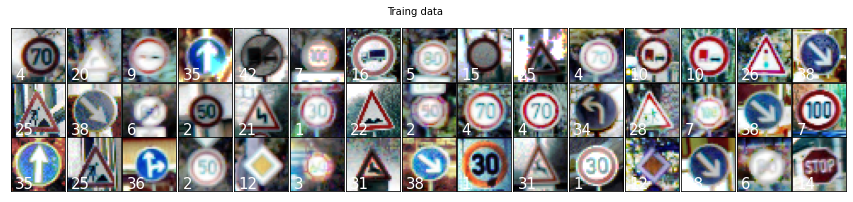

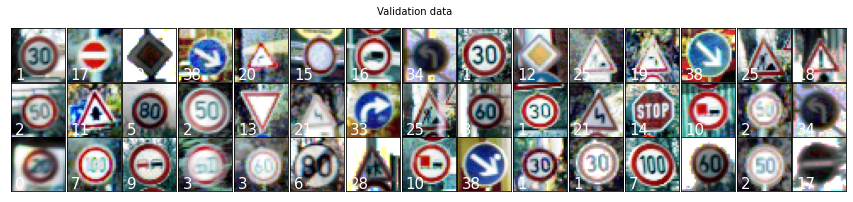

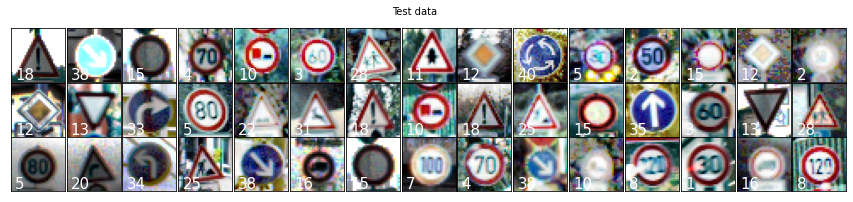

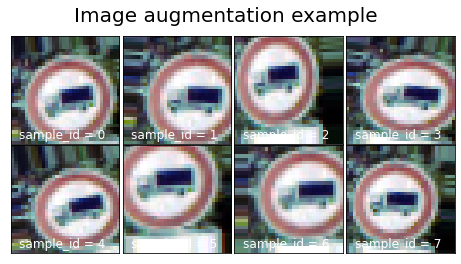

In [4]:
# Read all the Traffic Sign data
X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = preprocessData(DATA_PATH)

print("X_train.shape = {}".format(X_train.shape))
print("y_tain.shape = {}".format(y_train.shape))
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

# Plot first 44 examples of X_train and X_test
plotImages(X_train, labels_train, title="Traing data")
plotImages(X_val, labels_val, title="Validation data")
plotImages(X_test, labels_test, title="Test data")

# Plot Augmentation Example
plotAugmentationExample(image=X_train[6])


## Aufbau des Modells
Zum Aufbau deines Modells kannst du dich an die gezeigten Beispiele richten. Implementiere zuerst ein einfaches Modell, welches du je nach Performance erweitern kannst. 

Unten findest du die Auflistung der Schichten (Layers), die du für dein Modell miteinander kombinieren kannst. 


class RoadSignClassifier:Überlege dir, welche Layers für die Klassifikationsaufgabe mit HOG-Features gut sind und welche Layer sich für die Klassifikationsaufgabe mit ppm-Dateien eignen.

In [5]:
class RoadSignClassifier:
    """
    Classifier for 
    
    Attributes
    ----------
    self.name : String
        name of model
    width : Integer
        width of input images
    height : Integer
        heigth of input images
    depth : Integer
        

    

    """
    
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, N_classes, name):
        """
        Initialization of RoadSignClassifier instance
        
        """
        
        # Model name
        self.name = name
        
        # Dimensions of the data set
        self.width = X_train.shape[1]
        self.height = X_train.shape[2]
        self.depth = X_train.shape[3]
        
        # Data
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        
        # Labels
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.labels_train = None
        self.labels_test = None
        
        # Predicted Data
        self.y_test_pred = None
        self.labels_test_pred = None
        
        # Number of classes
        self.N_classes = N_classes
        
        # Instance of keras model
        self.model = None
        
        # Hyperparameters of model
        self.learning_rate = 0.001
        self.epochs = 20
        self.batch_size = 64
        self.patience = None
        
        # Augmentation Parameters
        self.rotation_range = 10
        self.zoom_range = 0.15
        self.width_shift_range = 0.1
        self.height_shift_range = 0.1
        self.shear_range = 0.15
        self.horizontal_flip = False
        self.vertical_flip = False
        
        # Training history
        self.training_hist = None
        
        # Evaluation
        self.classification_report = None
        self.test_accuracy = None
        self.confusion_matrix = None
        self.unique_labels = None
        
    
    def createModel(self):
        """
        Creates Sequential model using tensorflow keras
        """
        
        # Define input shape
        inputShape = (self.height, self.width, self.depth)
        
        # Initialize model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=inputShape, activation="relu"))
        
        model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
        model.add(tf.keras.layers.Dense(self.N_classes, activation="softmax"))
        
        # Define optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.learning_rate, 
            decay=self.learning_rate / (self.epochs)
        )

        # Compile model
        model.compile(
            optimizer=optimizer, 
            loss="categorical_crossentropy", 
            metrics=["accuracy"]
        )
        
        self.model = model     
    
    def fit(self):
        """
        Definition of callbacks, specificaiton of data augmentation & fit of the model
        
        """
        
        # Specify early stopping criterion
        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True
        )

        # Perform data augmentation on the data, to increase the diversity of your training 
        # set by applying random (but realistic) transformations, such as image rotation.
        data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=self.rotation_range,
            zoom_range=self.zoom_range,
            width_shift_range=self.width_shift_range,
            height_shift_range=self.height_shift_range,
            shear_range=self.shear_range,
            horizontal_flip=self.horizontal_flip,
            vertical_flip=self.vertical_flip
        )

        # Fit model
        self.training_hist = self.model.fit(
            data_augmentation.flow(self.X_train, self.y_train, batch_size=self.batch_size),
            epochs=self.epochs,
            validation_data=(self.X_val, self.y_val),
            callbacks=callback,
            verbose=1
        )
        
        # Save model
        self.model.save('models/' + self.name)
        
    def evaluate(self):
        """
        Performs evaluation of the model based on test accuracy and confusion matrix
        
        """
        
        # Predict Test data
        self.y_test_pred = clf.model.predict(self.X_test)
        
        # Decode predicted one-hot-encoded labels
        self.labels_test_pred = one_hot_decode(self.labels_test, self.y_test_pred)
        
        # Compute classification report
        self.classification_report = classification_report(
            self.labels_test.astype(int), 
            self.labels_test_pred.astype(int)
        )
        print(self.classification_report)
                                           
        # Evalueate trained model with test data
        loss, self.test_accuracy = clf.model.evaluate(
            self.X_test,
            self.y_test,
            verbose=0
        )
        
        # Compute Confusion Matrix
        y_true = self.labels_test
        y_pred = self.labels_test_pred
        self.unique_labels = np.unique(self.labels_test.astype(int)).astype(str)
        self.confusion_matrix = confusion_matrix(y_true, y_pred, labels=self.unique_labels)
        
        # Save classification report as .txt file
        filename = "models/" + "report_" + clf.name
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print(self.classification_report, file=f)
            print("Test loss = {}".format(loss), file=f)
            print("Test accuracy = {}".format(self.test_accuracy), file=f)
    
    def plotLossHistory(self):
        """
        Plots training history
        
        """
        loss_history = self.training_hist.history['loss']
        validation_loss = self.training_hist.history['val_loss']
        
        fontsize = 12

        %matplotlib inline
        plt.figure(dpi=90)
        plt.semilogy(loss_history)
        plt.semilogy(validation_loss)
        plt.title("Training history of {}".format(clf.name), fontsize=fontsize)
        plt.xlabel("Epoch", fontsize=fontsize)
        plt.ylabel("Loss", fontsize=fontsize)
        plt.legend(['loss', 'validation_loss'], fontsize=fontsize)
        
        # Save figure
        filename = "figures/traning_hist_" + clf.name
        plt.savefig(filename)
        plt.show()
        
        

In [6]:
clf = RoadSignClassifier(X_train, X_val, X_test, y_train, y_val, y_test, N_classes=43, name="model_1")

# Labels
clf.labels_train = labels_train
clf.labels_val = labels_val
clf.labels_test = labels_test

# Set hyperparameters of model
clf.learning_rate = 0.001
clf.epochs = 50
clf.batch_size = 64
clf.patience = 10

# Set augmentation Parameters
clf.rotation_range = 10
clf.zoom_range = 0.15
clf.width_shift_range = 0.1
clf.height_shift_range = 0.1
clf.shear_range = 0.15
clf.horizontal_flip = False
clf.vertical_flip = False

# Create Model
clf.createModel()

# Fit Model
clf.fit()

Epoch 1/50
429/429 [==============================] - 32s 73ms/step - loss: 1.0460 - accuracy: 0.7096 - val_loss: 0.3279 - val_accuracy: 0.8878
Epoch 2/50
429/429 [==============================] - 31s 73ms/step - loss: 0.2005 - accuracy: 0.9398 - val_loss: 0.0904 - val_accuracy: 0.9708
Epoch 3/50
429/429 [==============================] - 31s 73ms/step - loss: 0.1055 - accuracy: 0.9674 - val_loss: 0.0585 - val_accuracy: 0.9815
Epoch 4/50
429/429 [==============================] - 32s 75ms/step - loss: 0.0770 - accuracy: 0.9768 - val_loss: 0.0360 - val_accuracy: 0.9876
Epoch 5/50
429/429 [==============================] - 31s 73ms/step - loss: 0.0670 - accuracy: 0.9791 - val_loss: 0.0329 - val_accuracy: 0.9886
Epoch 6/50
429/429 [==============================] - 32s 74ms/step - loss: 0.0555 - accuracy: 0.9832 - val_loss: 0.0254 - val_accuracy: 0.9922
Epoch 7/50
429/429 [==============================] - 32s 74ms/step - loss: 0.0451 - accuracy: 0.9856 - val_loss: 0.0412 - val_accuracy:

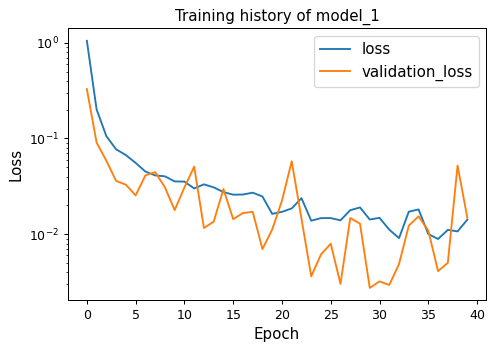

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00       332
           2       1.00      1.00      1.00       360
           3       1.00      1.00      1.00       221
           4       1.00      1.00      1.00       287
           5       1.00      0.99      1.00       295
           6       1.00      1.00      1.00        62
           7       1.00      1.00      1.00       202
           8       0.99      1.00      0.99       229
           9       1.00      1.00      1.00       227
          10       1.00      1.00      1.00       297
          11       0.99      1.00      1.00       189
          12       1.00      1.00      1.00       322
          13       1.00      1.00      1.00       300
          14       1.00      1.00      1.00       120
          15       1.00      0.99      0.99        92
          16       1.00      1.00      1.00        59
          17       1.00    

In [7]:
# Plot loss history
clf.plotLossHistory()

# Evaluate Model
clf.evaluate()

<AxesSubplot:title={'center':'Confusion matrix with ony false classificaitons'}>

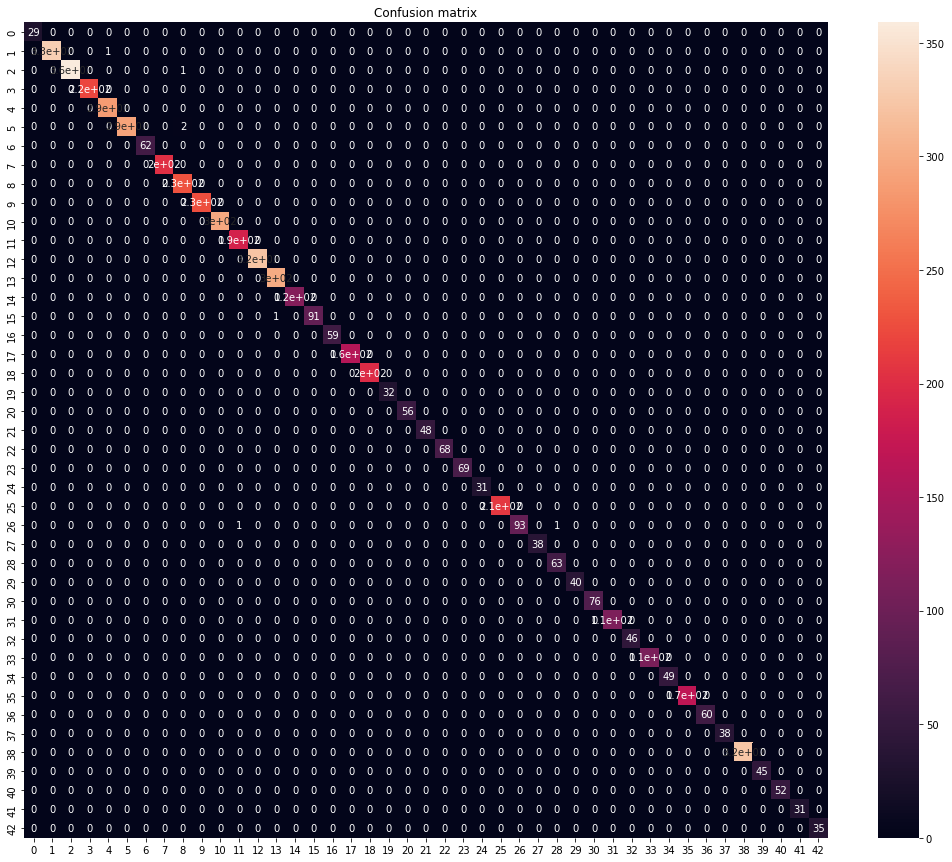

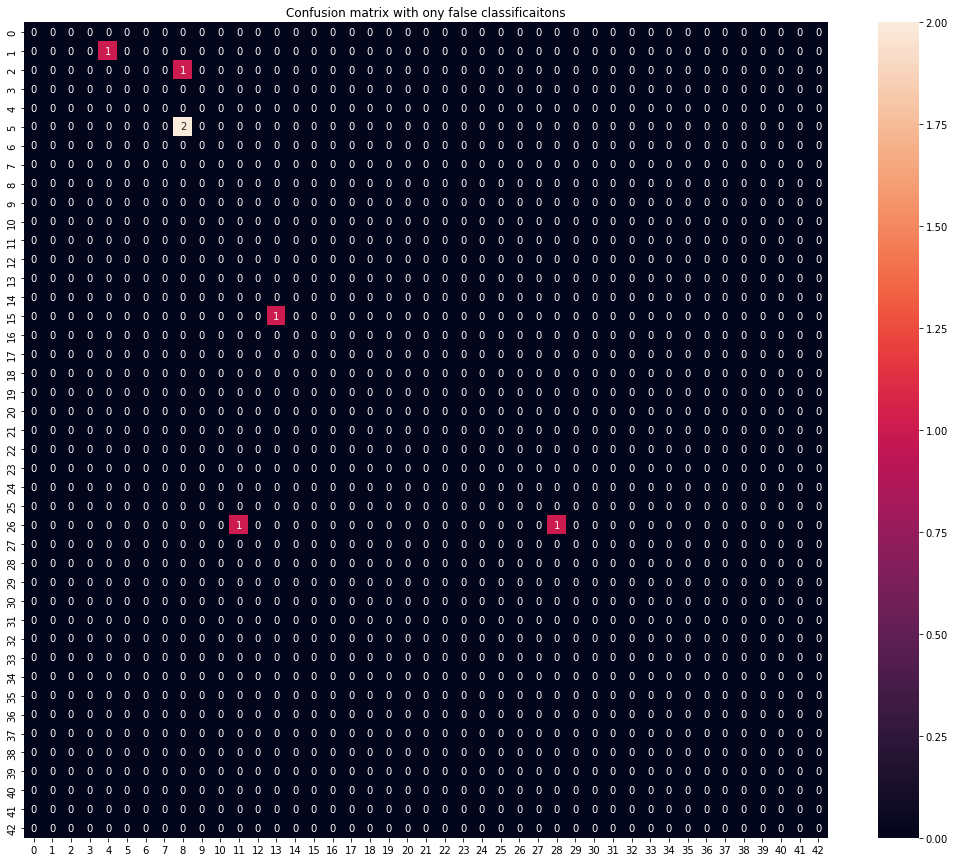

In [8]:
# Define confusion matrix
conf_matrix = clf.confusion_matrix
unique_labels = clf.unique_labels

# Plot confusion matrix
df_cm = pd.DataFrame(conf_matrix, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True)


# Plot matrix of only false classifications
conf_matrix_normalized = conf_matrix - np.diag(conf_matrix) * np.eye(len(conf_matrix))
df_cm_normalized = pd.DataFrame(conf_matrix_normalized, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix with ony false classificaitons")
sn.heatmap(df_cm_normalized, annot=True)

## Nutzen des trainierten Modells zum Vorhersagen von Verkehrszeichen-Klassen 
Zum Wiederverwenden des trainierten gespeicherten Modells kann die [load_model](https://keras.io/api/models/model_saving_apis/#loadmodel-function)-Funktionverwendet werden.

Eine detaillierte Beschreibung der [predict](https://keras.io/api/models/model_training_apis/#predict-method)-Methode findest du in Keras API Referenz.

In [9]:
# Lade das trainierte Modell und teste die Erkennung der Verkehrszeichen-Klassen mit eigenen Beispielen
